# Compare Manual to Automatic Meander Characterization

In this code we will compare the manual to the automatic detection


## Start Script
### Importing Packages

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [2]:
# Importing Packages
import os
import time
import copy
import numpy as np
import pandas as pd
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from IPython.display import Image, display, HTML
from joblib import Parallel, delayed
import plotly.io as pio
import ipywidgets as widgets
from IPython.display import display
from scipy.spatial import Delaunay
from scipy.spatial.distance import euclidean

# Importing pyMeander Packages
from WigglyRivers import RiverDatasets
from WigglyRivers import RiverFunctions as RF
from WigglyRivers import ExtractNHDPlusHRData as NHD
from WigglyRivers.utilities import utilities as utl
from WigglyRivers.utilities import filesManagement as FM
from WigglyRivers import Logger
from WigglyRivers import WaveletTreeFunctions as WTFunc
from WigglyRivers import CompareMeanders as CM

In [3]:
def convert_str_float_list_vector(x_val):
    x_val = x_val.replace('[', '').replace(']', '').replace('\n', ',').replace(
        ' ', ',').split(',')
    x_val = np.array([float(x) for x in x_val if x != ''])
    return  x_val

In [4]:
# Start Logger
logger = Logger(console=True)

2024-01-27 09:24:42,721[INFO] set_logger: Starting log


In [5]:
# Parameters
path_projects = './meander_comparison/characterization/manual_corrected/'
projects = utl.get_folders(path_projects)
path_projects_all = [f'{path_projects}{p}/' for p in projects]
path_projects_c = './meander_comparison/characterization/manual_with_automatic/'
path_projects_out = [f'{path_projects_c}{p}/' for p in projects]

print(projects)

# Current projection of information
projection = 'esri:102003'

['0104', '0106', '0107', '0307', '0406', '0408', '0412', '0504', '0510', '0601', '0701', '0708', '0714', '0803', '0808', '0904', '1002', '1006', '1009', '1017', '1021', '1030', '1108', '1110', '1113', '1202', '1206', '1208', '1211', '1305', '1307', '1402', '1404', '1406', '1701']


## Extract Data

In [14]:
# Open databases
bounds_array_str = 'extended'
data_link = {}
for i_m, project in enumerate(projects):
    print(project)
    try:
        i_p = projects.index(project)
    except ValueError:
        raise ValueError(f'Project "{project}" not found')

    project_to_load = path_projects_out[i_p]
    # Load Meander database
    database = FM.load_data(
        f'{project_to_load}/meander_database_{bounds_array_str}.feather',
        pandas_dataframe=True)

    # Check common meanders between automatic and manual
    auto_df = database[database['automatic_flag'] == 1]
    manual_df = database[database['automatic_flag'] == 0]

    # Compare manual to automatic meanders
    database = CM.extract_closet_meanders(
        manual_df, auto_df, link_x='x', link_y='y')
    
    # Save database
    FM.save_data(database, path_output=f'{project_to_load}/',
                 file_name=f'compare_manual_auto_{bounds_array_str}.csv')
    
    if i_m == 0:
        database_all = database.copy()
    else:
        database_all = pd.concat([database_all, database], ignore_index=True)

FM.save_data(database_all, path_output=f'./meander_comparison/characterization/',
                file_name=f'compare_manual_auto_{bounds_array_str}_all.csv')



0104
0106
0107
0307
0406
0408
0412
0504
0510
0601
0701
0708
0714
0803
0808
0904
1002
1006
1009
1017
1021
1030
1108
1110
1113
1202
1206
1208
1211
1305
1307
1402
1404
1406
1701


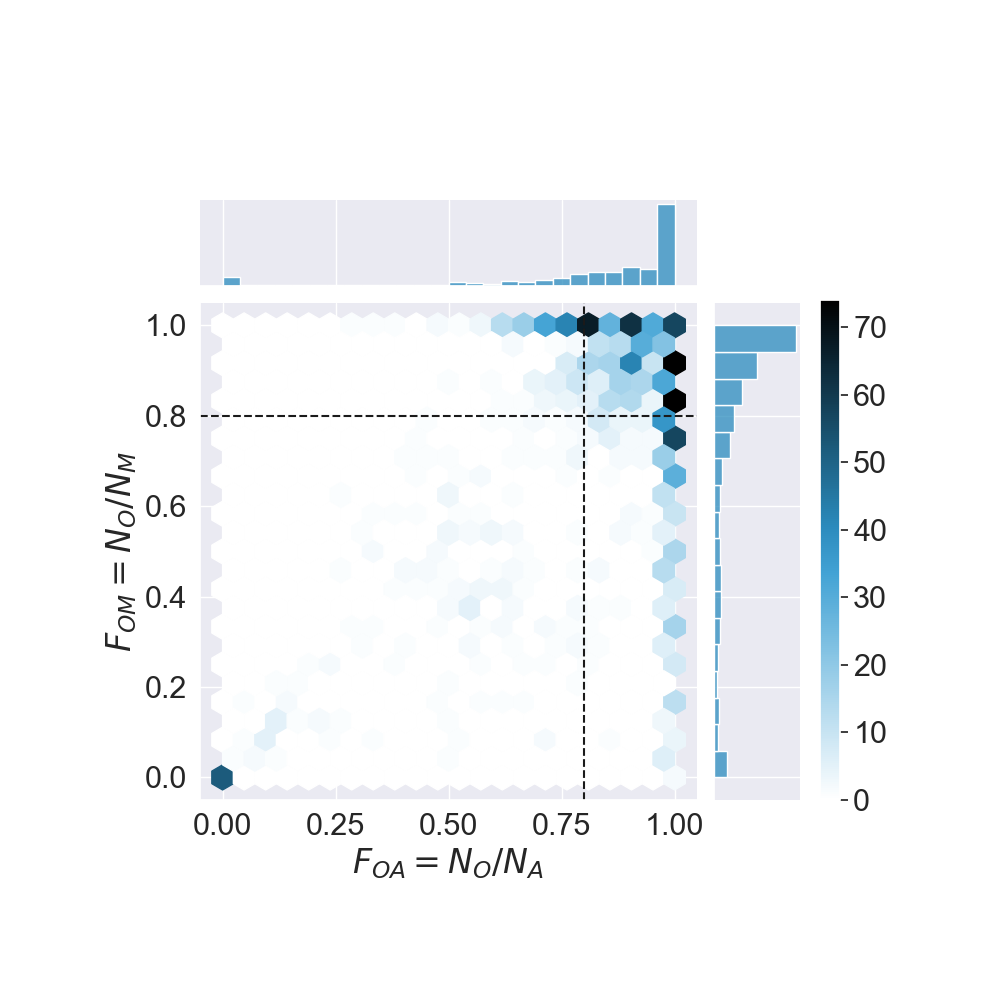

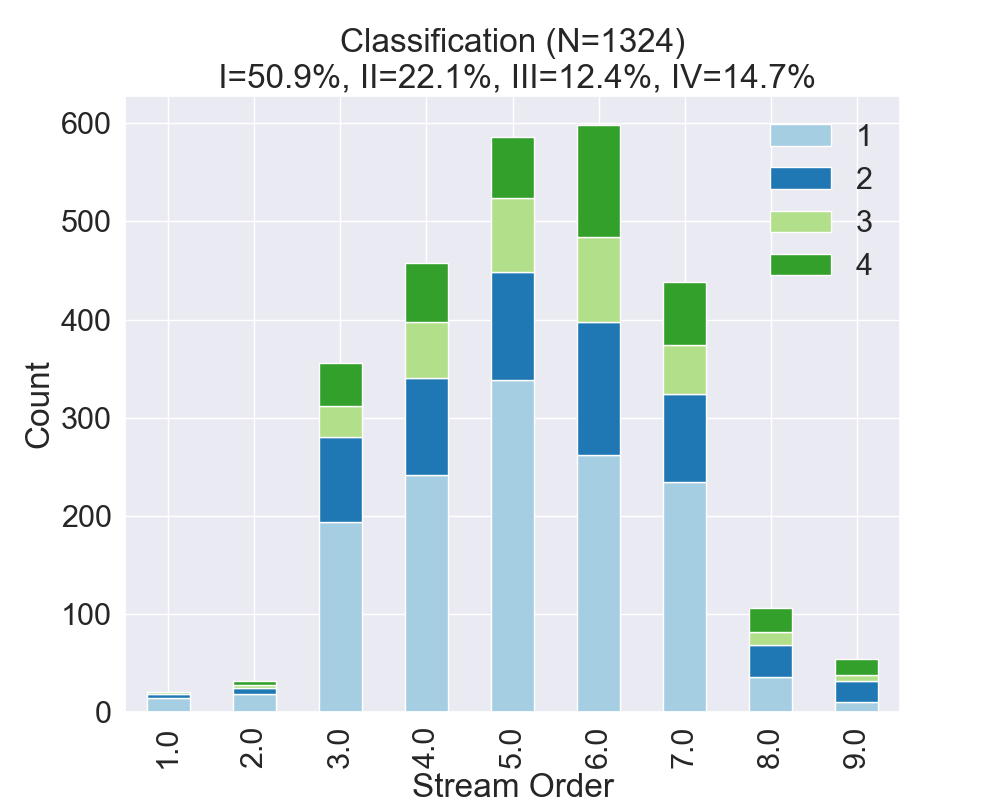

In [15]:
# Look comparison
bounds_array_str = 'extended'
utl.cr_folder('../results/wavelet_analysis/comparison_meanders/')
data_link = FM.load_data('./meander_comparison/characterization/'
                         f'compare_manual_auto_{bounds_array_str}_all.csv',
                         pandas_dataframe=True)

classification = ['I', 'II', 'III', 'IV']
c_colors = ['r', 'g', 'b', 'y']

sns.set(font_scale=2)
# Plot hexbin
hexplot = sns.jointplot(data=data_link, x='f_oa', y='f_om', kind='hex',
              color='#2b8cbe',
              xlim=(-0.05, 1.05),
              ylim=(-0.05, 1.05), height=10)
plt.axhline(y=0.8, color='k', linestyle='--')
plt.axvline(x=0.8, color='k', linestyle='--')
plt.xlabel(r'$F_{OA}=N_O/N_A$')
plt.ylabel(r'$F_{OM}=N_O/N_M$')
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
cbar_ax = hexplot.fig.add_axes([.82, .20, .02, .5])
plt.colorbar(cax=cbar_ax)
plt.show()
# plt.savefig('../results/wavelet_analysis/comparison_meanders/hexbin.png',
#             dpi=300)
# plt.savefig('../results/wavelet_analysis/comparison_meanders/hexbin.pdf',
#             dpi=300)
# plt.close('all')

# Plot summary of the classification
data_plot = data_link.loc[:, ['so_1', 'Zone']]
dp_2 = data_plot.groupby(['Zone']).count()
dp = data_plot.pivot_table(values='Zone',
                           index=['so_1'], columns=['Zone'],
                           aggfunc=np.size)
colors = [
    '#a6cee3',
    '#1f78b4',
    '#b2df8a',
    '#33a02c',
]
total = len(data_plot)
title = (f'Classification (N={total})\n '
         f'I={dp_2.loc[1, "so_1"]/total*100:.1f}%, '
         f'II={dp_2.loc[2, "so_1"]/total*100:.1f}%, '
         f'III={dp_2.loc[3, "so_1"]/total*100:.1f}%, '
         f'IV={dp_2.loc[4, "so_1"]/total*100:.1f}%')
dp.plot(kind='bar', stacked=True, figsize=(10, 8), color=colors,
        title=title)
plt.legend(title=None, frameon=False)
plt.xlabel('Stream Order')
plt.ylabel('Count')
plt.show()
# plt.savefig('./results/wavelet_analysis/comparison_meanders/'
#             'classification.png', dpi=300)
# plt.savefig('./results/wavelet_analysis/comparison_meanders/'
#             'classification.pdf', dpi=300)
# plt.close('all')

In [43]:
subset_df['huc04_n_2']

2       0104_0
4       0104_0
6       0104_0
7       0104_0
8       0104_0
         ...  
1269    1701_0
1271    1701_0
1272    1701_0
1273    1701_0
1274    1701_0
Name: huc04_n_2, Length: 864, dtype: object

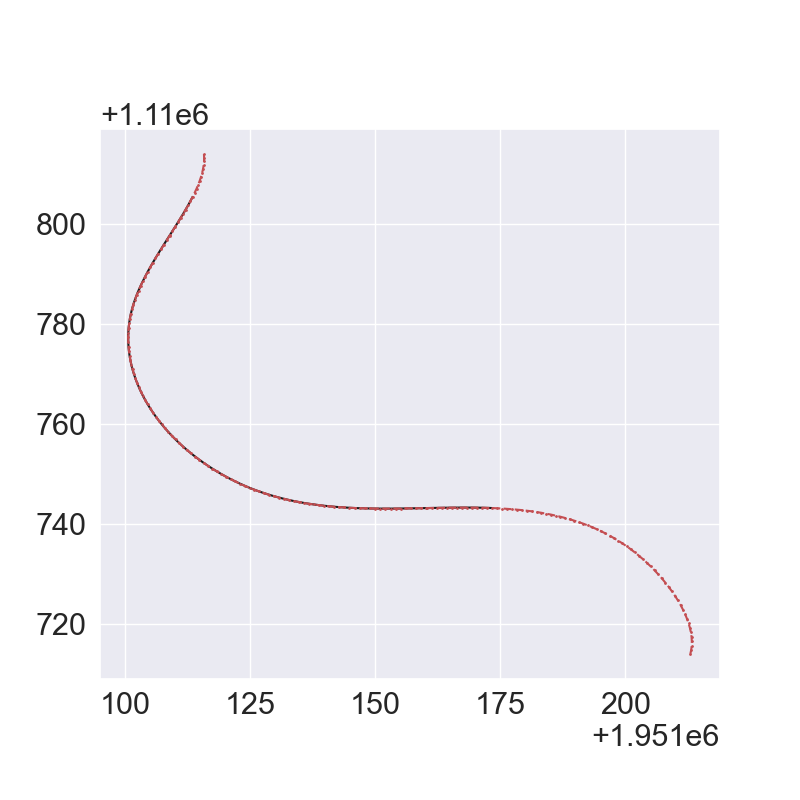

In [18]:
# Look at individual meanders 
bounds_array_str = 'extended'
utl.cr_folder('../results/wavelet_analysis/comparison_meanders/')
data_link = FM.load_data('./meander_comparison/characterization/'
                         f'compare_manual_auto_{bounds_array_str}_all.csv',
                         pandas_dataframe=True)

# Extract in specific Zone 1
subset_df = data_link[data_link['Zone'] == 3]
i_m = 0
x_m = convert_str_float_list_vector(subset_df['x_1'].values[i_m]) 
y_m = convert_str_float_list_vector(subset_df['y_1'].values[i_m])

x_a = convert_str_float_list_vector(subset_df['x_2'].values[i_m])
y_a = convert_str_float_list_vector(subset_df['y_2'].values[i_m])

plt.figure(figsize=(8, 8))
plt.plot(x_m, y_m, 'k', label='Manual')
plt.plot(x_a, y_a, 'ro--', label='Auto', markersize=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()



